In [ ]:
# I should note that none of this works. Actually... zip codes that start with 06 are not in california... fml

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

In this notebook we are attempting a simple OLS regression on rent prices for 2018 using 10 features I pulled from the census acs 2018 zip codes dataset. For reference, I used the query below. 

SELECT geo_id, total_pop, white_pop, black_pop, \
asian_pop, hispanic_pop, median_income, median_rent, \
bachelors_degree_or_higher_25_64, bachelors_degree, \
mobile_homes \
FROM `bigquery-public-data.census_bureau_acs.zip_codes_2018_5yr` \
WHERE geo_id LIKE '06%' --Selecting CA \

In [1]:
# Let's go ahead and pull in that data
feats = pd.read_csv('zip_codes_2018_5yr_10_useful_cols.csv')
targets = pd.read_csv('Zip_Zri_MultiFamilyResidenceRental.csv')

In [32]:
feats = feats.dropna()
feats

,geo_id,total_pop,white_pop,black_pop,asian_pop,hispanic_pop,median_income,median_rent,bachelors_degree_or_higher_25_64,bachelors_degree,mobile_homes
0,6263,251.0,241.0,0.0,0.0,0.0,46116.0,781.0,12.0,12.0,0.0
1,6426,3509.0,3031.0,241.0,116.0,21.0,106991.0,1003.0,910.0,1067.0,0.0
2,6412,4268.0,4030.0,19.0,82.0,137.0,92417.0,1213.0,1000.0,819.0,0.0
3,6331,5074.0,4839.0,60.0,89.0,30.0,92835.0,926.0,679.0,514.0,6.0
4,6796,931.0,886.0,3.0,17.0,25.0,91071.0,783.0,196.0,226.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
242,6790,34653.0,28236.0,935.0,864.0,3948.0,63514.0,768.0,4423.0,3572.0,10.0
243,6053,34772.0,17710.0,3152.0,1591.0,11229.0,50698.0,850.0,4362.0,3333.0,26.0
244,6450,34884.0,21562.0,2810.0,625.0,9275.0,61031.0,896.0,4785.0,3896.0,48.0
245,6516,54918.0,27252.0,10496.0,2489.0,12952.0,58112.0,967.0,7549.0,5536.0,37.0


In [80]:
feats = pd.read_csv('zip_codes_2018_5yr_10_useful_cols.csv', dtype={'geo_id': str})
feats

,geo_id,total_pop,white_pop,black_pop,asian_pop,hispanic_pop,median_income,median_rent,bachelors_degree_or_higher_25_64,bachelors_degree,mobile_homes
0,06263,251.0,241.0,0.0,0.0,0.0,46116.0,781.0,12.0,12.0,0.0
1,06426,3509.0,3031.0,241.0,116.0,21.0,106991.0,1003.0,910.0,1067.0,0.0
2,06412,4268.0,4030.0,19.0,82.0,137.0,92417.0,1213.0,1000.0,819.0,0.0
3,06331,5074.0,4839.0,60.0,89.0,30.0,92835.0,926.0,679.0,514.0,6.0
4,06796,931.0,886.0,3.0,17.0,25.0,91071.0,783.0,196.0,226.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
278,06090,857.0,811.0,0.0,0.0,24.0,155691.0,NaN,337.0,228.0,0.0
279,06755,1050.0,899.0,0.0,0.0,132.0,95143.0,NaN,183.0,194.0,0.0
280,06390,183.0,175.0,0.0,0.0,4.0,NaN,NaN,50.0,36.0,4.0
281,06785,686.0,581.0,20.0,54.0,18.0,74773.0,NaN,151.0,139.0,0.0


In [8]:
targets

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,2930.0,2952.0,2926.0,...,3484.0,3523.0,3573.0,3622.0,3664.0,3698.0,3704.0,3692.0,3715.0,3676.0
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,1447.0,1465.0,1469.0,...,1731.0,1749.0,1768.0,1787.0,1801.0,1806.0,1789.0,1761.0,1747.0,1731.0
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,2797.0,2811.0,2813.0,...,3449.0,3459.0,3479.0,3491.0,3510.0,3521.0,3574.0,3608.0,3561.0,NaN
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,NaN,NaN,NaN,...,1226.0,1250.0,1264.0,1251.0,1246.0,1252.0,1280.0,1310.0,1294.0,1286.0
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,1437.0,1469.0,1490.0,...,1888.0,1911.0,1934.0,1950.0,1953.0,1952.0,1921.0,1958.0,NaN,1916.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,90755,75202,Dallas,TX,Dallas-Fort Worth-Arlington,Dallas County,1857,997.0,1019.0,1042.0,...,1615.0,1619.0,1628.0,NaN,NaN,1729.0,1697.0,1739.0,NaN,NaN
1857,94610,84627,Ephraim,UT,NaN,Sanpete County,1858,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1298.0,NaN
1858,84452,60301,Oak Park,IL,Chicago-Naperville-Elgin,Cook County,1859,NaN,NaN,NaN,...,1447.0,1483.0,1495.0,1511.0,1537.0,1570.0,1580.0,1625.0,NaN,NaN
1859,94629,84647,Mount Pleasant,UT,NaN,Sanpete County,1860,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1221.0


In [18]:
# keep only RegionID and 2018 cols
#targets[['RegionID', ]]
#targets.columns
vals_2018 = targets.filter(regex='2018')

In [20]:
vals_2018['average'] = vals_2018.mean(axis=1)

/var/folders/rs/ck6nby4n2s365r7sdf740jt00000gn/T/ipykernel_74273/750822285.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_2018['average'] = vals_2018.mean(axis=1)


In [23]:
vals_2018

,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,average
0,3727.0,3671.0,3591.0,3556.0,3545.0,3519.0,3545.0,3570.0,3609.0,3640.0,3638.0,3612.0,3601.916667
1,1735.0,1727.0,1740.0,1758.0,1780.0,1800.0,1802.0,1794.0,1783.0,1773.0,1755.0,1738.0,1765.416667
2,3609.0,3602.0,3580.0,3573.0,3556.0,3500.0,3508.0,3507.0,3533.0,3567.0,3579.0,3584.0,3558.166667
3,1214.0,1218.0,1214.0,1222.0,1233.0,1237.0,1225.0,1223.0,1228.0,1244.0,1251.0,1282.0,1232.583333
4,1836.0,1840.0,1856.0,1866.0,1886.0,1928.0,1944.0,1940.0,1929.0,1915.0,1896.0,1887.0,1893.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,1505.0,1494.0,1504.0,1504.0,1496.0,1522.0,1567.0,1602.0,1650.0,1620.0,1613.0,1605.0,1556.833333
1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1858,1451.0,1457.0,1490.0,1511.0,1520.0,1547.0,1540.0,1558.0,1535.0,1498.0,NaN,1420.0,1502.454545
1859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
vals_2018['geo_id'] = targets['RegionName']

/var/folders/rs/ck6nby4n2s365r7sdf740jt00000gn/T/ipykernel_74273/1561600280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals_2018['geo_id'] = targets['RegionName']


In [28]:
vals_2018 = vals_2018[['geo_id', 'average']]

In [30]:
vals_2018 = vals_2018.dropna()

In [31]:
vals_2018

,geo_id,average
0,10025,3601.916667
1,60657,1765.416667
2,10023,3558.166667
3,77494,1232.583333
4,60614,1893.583333
...,...,...
1853,78215,1232.666667
1854,2142,3052.600000
1855,18232,775.333333
1856,75202,1556.833333


In [34]:
merged = pd.merge(feats, vals_2018, on='geo_id')
merged

,geo_id,total_pop,white_pop,black_pop,asian_pop,hispanic_pop,median_income,median_rent,bachelors_degree_or_higher_25_64,bachelors_degree,mobile_homes,average
0,6706,14191.0,5201.0,1747.0,684.0,6072.0,41902.0,731.0,1000.0,689.0,0.0,920.833333
1,6418,12669.0,8435.0,628.0,369.0,2920.0,56073.0,893.0,1664.0,1330.0,0.0,1215.916667
2,6519,15997.0,2243.0,5718.0,132.0,7370.0,28955.0,894.0,1029.0,710.0,0.0,1266.250000
3,6610,23275.0,3486.0,7672.0,757.0,10716.0,46210.0,883.0,2132.0,1763.0,16.0,1310.666667
4,6405,27825.0,24461.0,341.0,1143.0,1449.0,80073.0,1148.0,7032.0,5206.0,244.0,1323.166667
5,6905,20493.0,13084.0,1240.0,2483.0,3121.0,122723.0,1867.0,6760.0,4141.0,8.0,2048.714286
6,6401,18787.0,11467.0,2330.0,300.0,4327.0,53704.0,903.0,2131.0,1500.0,8.0,1213.750000
7,6489,33620.0,30121.0,506.0,1217.0,1513.0,90883.0,907.0,7698.0,5639.0,454.0,1252.166667
8,6042,23353.0,13208.0,2471.0,3992.0,2681.0,79392.0,1239.0,6834.0,4424.0,21.0,1214.571429
9,6340,30764.0,20118.0,2511.0,1754.0,4809.0,61980.0,1136.0,4628.0,3335.0,628.0,1131.333333


In [56]:
X = merged.drop(columns=['average', 'geo_id'])
y = merged['average']

In [60]:
mlr = LinearRegression()
mlr_scores = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    mlr.fit(X_train, y_train)
    mlr_scores.append(mlr.score(X_test, y_test))

In [61]:
scores = pd.DataFrame({'score':mlr_scores,'model':'mlr'})

<AxesSubplot:xlabel='score', ylabel='Density'>

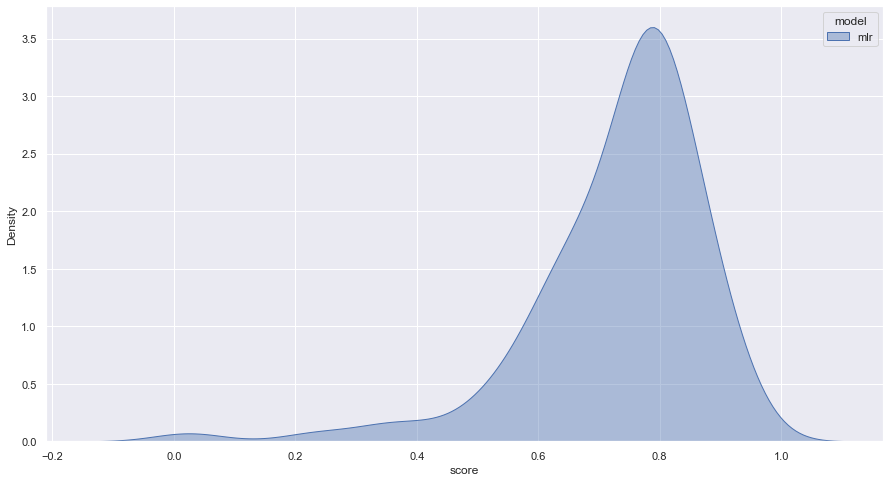

In [62]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.kdeplot(data=scores, x="score", hue="model", fill=True, common_norm=False, alpha=0.4)

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

                            feature          VIF
0                         total_pop  9585.072947
1                         white_pop  3643.914481
2                         black_pop   359.389599
3                         asian_pop    50.070401
4                      hispanic_pop   857.401523
5                     median_income    83.143371
6                       median_rent    81.713422
7  bachelors_degree_or_higher_25_64   111.829835
8                  bachelors_degree   154.029140
9                      mobile_homes     1.974405


In [77]:
import statsmodels.api as sm 
X_add_const = sm.add_constant(X)#(X.drop(columns='median_rent'))
ols = sm.OLS(y, X_add_const)
ans = ols.fit()
print(ans.summary())

                            OLS Regression Results                            
Dep. Variable:                average   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     34.83
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           6.69e-18
Time:                        16:09:21   Log-Likelihood:                -340.96
No. Observations:                  56   AIC:                             703.9
Df Residuals:                      45   BIC:                             726.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [73]:
ans.bic

726.2006592024952

<AxesSubplot:xlabel='median_rent', ylabel='average'>

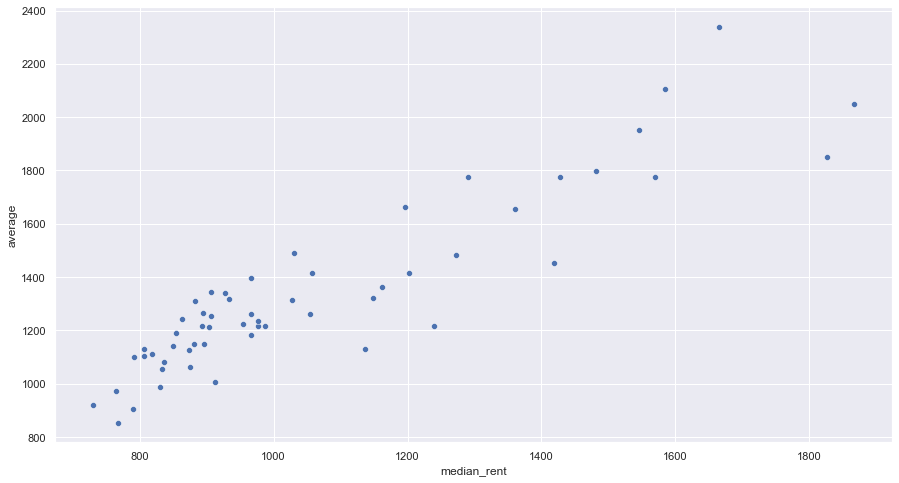

In [74]:
sns.scatterplot(data=merged, x="median_rent", y="average")